In [146]:
import torch
from torch import nn

In [147]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!unzip "/content/new_dataset.zip"

In [159]:
train_dir = "/content/new_dataset/train"
test_dir = "/content/new_dataset/test"
train_dir

'/content/new_dataset/train'

In [151]:
import requests
import zipfile
from pathlib import Path
image_path = Path("new_dataset/train/")

Image shape:  (150, 150)


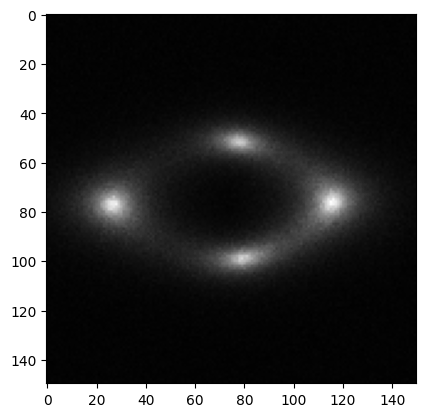

In [152]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
file_path = '/content/new_dataset/train/no/18.npy'
array_data = np.load(file_path)

# If the array has a singleton dimension, remove it
if array_data.shape[0] == 1:
    array_data = array_data[0]

# Display the image
print("Image shape: ", array_data.shape)
# print(array_data)
plt.imshow(array_data, cmap='gray')  # Assuming it's a grayscale image, change cmap as needed
plt.show()


In [153]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [156]:
image_path_list = list(image_path.glob("*/*.npy"))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


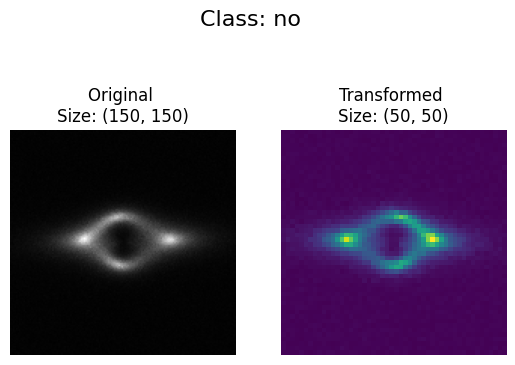

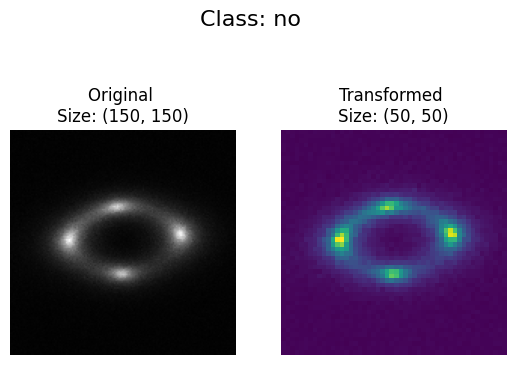

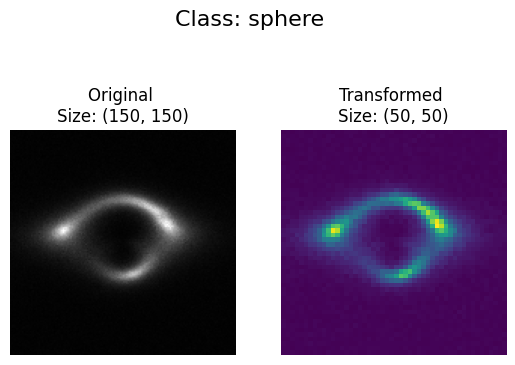

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform, and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)

    # Adjust n if it's larger than the number of available images
    n = min(n, len(image_paths))

    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        # Load .npy file using np.load()
        array_data = np.load(image_path)

        # Remove singleton dimension if it exists
        if array_data.shape[0] == 1:
            array_data = array_data[0]

        # Convert NumPy array to PyTorch tensor
        tensor_data = torch.from_numpy(array_data).float()

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(array_data, cmap='gray')  # Assuming it's a grayscale image, adjust cmap as needed
        ax[0].set_title(f"Original \nSize: {array_data.shape}")
        ax[0].axis("off")

        # Transform and plot image
        if tensor_data.dim() == 2:  # Single-channel image
            transformed_image = transform(tensor_data.unsqueeze(0)).squeeze(0).numpy()
        else:  # Multi-channel image
            # Convert sparse tensor to dense tensor before permutation
            transformed_image = transform(tensor_data.to_dense()).permute(0, 2, 3, 1).numpy()

        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        # Assuming the class information is in the path, adjust this as needed
        class_label = image_path.parent.stem
        fig.suptitle(f"Class: {class_label}", fontsize=16)

# Define a new transformation with a specific output size
data_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.Lambda(lambda x: x / 255.0),
    # Adjust this size according to your needs
    # Add other transformations as needed
])

# Ensure that image_path_list is not empty
if image_path_list:
    plot_transformed_images(image_path_list,
                            transform=data_transform,
                            n=3)
else:
    print("No images found in image_path_list.")


In [161]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

class NpyDatasetWithLabels(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = []
        self.file_list = self._list_files()
        self.classes = ['no', 'sphere', 'vort']
        # Map class names to integer labels
        self.class_to_idx = {'no' : 0, 'sphere': 1, 'vort':2}
        # self.labels = [self.class_to_idx[file.split('_')[0]] for file in self.file_list]

    def _list_files(self):
        file_list = []
        for dirpath, dirnames, filenames in os.walk(self.root_dir):
            for filename in filenames:
                if filename.endswith('.npy'):
                    file_path = os.path.join(dirpath, filename)
                    file_list.append(os.path.join(dirpath, filename))
                    parent_dir = os.path.basename(os.path.dirname(file_path))
                    if(parent_dir == 'no'):
                        self.labels.append(0)
                    elif(parent_dir == 'sphere'):
                      self.labels.append(1)
                    elif(parent_dir == 'vort'):
                      self.labels.append(2)
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        array_data = np.load(file_path)

        if self.transform:
            tensor_data = torch.from_numpy(array_data).float()
            tensor_data = self.transform(tensor_data)

        label = self.labels[idx]

        return tensor_data, label

    def __repr__(self):
        header = f"Dataset {self.__class__.__name__}\n"
        info = (
            f"    Number of datapoints: {len(self)}\n"
            f"    Root location: {self.root_dir}\n"
            f"    StandardTransform\n"
            f"Transform: {self.transform}\n"
        )
        return header + info

# Example usage:
data_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.Lambda(lambda x: x / 255.0),  # Adjust as needed
])

train_data = NpyDatasetWithLabels(root_dir=train_dir, transform=data_transform)
test_data = NpyDatasetWithLabels(root_dir=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")



Train data:
Dataset NpyDatasetWithLabels
    Number of datapoints: 306
    Root location: /content/new_dataset/train
    StandardTransform
Transform: Compose(
    Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
)

Test data:
Dataset NpyDatasetWithLabels
    Number of datapoints: 198
    Root location: /content/new_dataset/test
    StandardTransform
Transform: Compose(
    Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
)



In [162]:
# Get class names as a list
class_names = train_data.classes
class_names

['no', 'sphere', 'vort']

In [163]:
class_dict = train_data.class_to_idx
class_dict

{'no': 0, 'sphere': 1, 'vort': 2}

In [164]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.0091, 0.0079, 0.0081,  ..., 0.0139, 0.0076, 0.0072],
         [0.0107, 0.0110, 0.0093,  ..., 0.0149, 0.0093, 0.0109],
         [0.0088, 0.0111, 0.0111,  ..., 0.0075, 0.0155, 0.0132],
         ...,
         [0.0135, 0.0121, 0.0109,  ..., 0.0107, 0.0095, 0.0097],
         [0.0137, 0.0121, 0.0114,  ..., 0.0099, 0.0086, 0.0100],
         [0.0116, 0.0163, 0.0107,  ..., 0.0164, 0.0163, 0.0093]]])
Image shape: torch.Size([1, 100, 100])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Original shape: torch.Size([1, 100, 100]) -> [color_channels, height, width]
Image permute shape: torch.Size([100, 100, 1]) -> [height, width, color_channels]


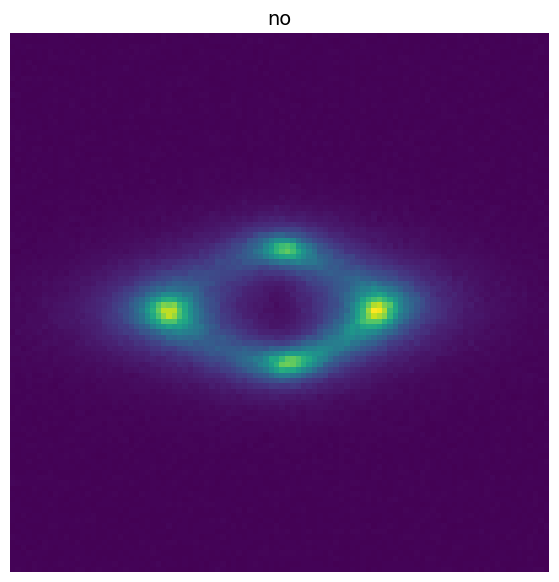

In [165]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [166]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd2771b3430>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd2771b3a00>)

In [167]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Image shape: torch.Size([1, 1, 100, 100]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [168]:
import torch.nn as nn
import torch.nn.functional as F

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, use_skip_connections=True, use_batch_norm=True, use_dropout=True) -> None:
        super(TinyVGG, self).__init__()
        self.use_skip_connections = use_skip_connections
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        # Convolutional blocks
        self.conv_block_1 = self._make_conv_block(input_shape, hidden_units)
        self.conv_block_2 = self._make_conv_block(hidden_units, hidden_units)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=10 * 25 * 25, out_features=output_shape)
        )

    def _make_conv_block(self, in_channels, out_channels):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
        if self.use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
        if self.use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        if self.use_dropout:
            layers.append(nn.Dropout(0.25))  # Adjust dropout rate as needed

        return nn.Sequential(*layers)

    def forward(self, x):
      x1 = self.conv_block_1(x)
      x2 = self.conv_block_2(x1)

      if self.use_skip_connections:
          # Adjust dimensions of x1 to match x2
          x1 = F.interpolate(x1, size=x2.shape[2:], mode='nearest')
          x2 = x2 + x1

      x = self.classifier(x2)
      return x


# Example usage:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=1, hidden_units=10, output_shape=len(train_data.classes), use_skip_connections=True, use_batch_norm=True, use_dropout=True).to(device)
print(model_0)


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [169]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Single image shape: torch.Size([1, 1, 100, 100])

Output logits:
tensor([[ 0.0247, -0.0029, -0.0385]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3435, 0.3341, 0.3224]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
2


In [170]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 1, 100, 100]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 50, 50]           --
│    └─Conv2d: 2-1                       [1, 10, 100, 100]         100
│    └─BatchNorm2d: 2-2                  [1, 10, 100, 100]         20
│    └─ReLU: 2-3                         [1, 10, 100, 100]         --
│    └─Conv2d: 2-4                       [1, 10, 100, 100]         910
│    └─BatchNorm2d: 2-5                  [1, 10, 100, 100]         20
│    └─ReLU: 2-6                         [1, 10, 100, 100]         --
│    └─MaxPool2d: 2-7                    [1, 10, 50, 50]           --
│    └─Dropout: 2-8                      [1, 10, 50, 50]           --
├─Sequential: 1-2                        [1, 10, 25, 25]           --
│    └─Conv2d: 2-9                       [1, 10, 50, 50]           910
│    └─BatchNorm2d: 2-10                 [1, 10, 50, 50]           20
│    └─ReLU:

In [171]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [172]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [173]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          # test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [174]:
# Set random seeds
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=1, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        # test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 1 | train_loss: 2.9704 | train_acc: 0.3105 | test_loss: 1.5112 | test_acc: 0.3434


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 2 | train_loss: 1.6646 | train_acc: 0.3464 | test_loss: 1.8066 | test_acc: 0.3333


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 3 | train_loss: 1.3849 | train_acc: 0.3529 | test_loss: 1.1747 | test_acc: 0.3485


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 4 | train_loss: 1.1667 | train_acc: 0.4020 | test_loss: 1.1370 | test_acc: 0.3636


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 5 | train_loss: 1.1242 | train_acc: 0.4052 | test_loss: 1.1495 | test_acc: 0.3232


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 6 | train_loss: 1.0881 | train_acc: 0.4118 | test_loss: 1.1549 | test_acc: 0.3788


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 7 | train_loss: 1.0591 | train_acc: 0.4248 | test_loss: 1.1926 | test_acc: 0.3636


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 8 | train_loss: 1.0332 | train_acc: 0.4510 | test_loss: 1.1888 | test_acc: 0.3384


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 9 | train_loss: 1.0210 | train_acc: 0.4575 | test_loss: 1.1437 | test_acc: 0.3687


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 10 | train_loss: 1.0247 | train_acc: 0.4673 | test_loss: 1.1134 | test_acc: 0.3737


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 11 | train_loss: 0.9915 | train_acc: 0.5163 | test_loss: 1.1928 | test_acc: 0.3030


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 12 | train_loss: 1.0050 | train_acc: 0.5131 | test_loss: 1.2000 | test_acc: 0.3636


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 13 | train_loss: 0.9999 | train_acc: 0.5065 | test_loss: 1.2136 | test_acc: 0.3485


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 14 | train_loss: 0.9990 | train_acc: 0.5033 | test_loss: 1.1332 | test_acc: 0.3889


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 15 | train_loss: 0.9848 | train_acc: 0.4935 | test_loss: 1.1696 | test_acc: 0.3485


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 16 | train_loss: 0.9977 | train_acc: 0.5294 | test_loss: 1.1279 | test_acc: 0.3384


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 17 | train_loss: 0.9547 | train_acc: 0.5490 | test_loss: 1.1367 | test_acc: 0.3838


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 18 | train_loss: 0.9541 | train_acc: 0.5261 | test_loss: 1.1919 | test_acc: 0.3788


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 19 | train_loss: 0.9176 | train_acc: 0.5621 | test_loss: 1.1636 | test_acc: 0.4040


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 20 | train_loss: 0.9515 | train_acc: 0.5163 | test_loss: 1.1985 | test_acc: 0.3687


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 21 | train_loss: 0.9112 | train_acc: 0.5686 | test_loss: 1.2286 | test_acc: 0.3990


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 22 | train_loss: 0.9180 | train_acc: 0.5294 | test_loss: 1.2122 | test_acc: 0.3737


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 23 | train_loss: 0.8920 | train_acc: 0.5850 | test_loss: 1.3508 | test_acc: 0.3889


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 24 | train_loss: 0.8976 | train_acc: 0.5817 | test_loss: 1.1757 | test_acc: 0.3687


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 25 | train_loss: 0.8827 | train_acc: 0.5686 | test_loss: 1.2584 | test_acc: 0.3788
Total training time: 67.957 seconds


In [175]:
from typing import Dict, List


In [176]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

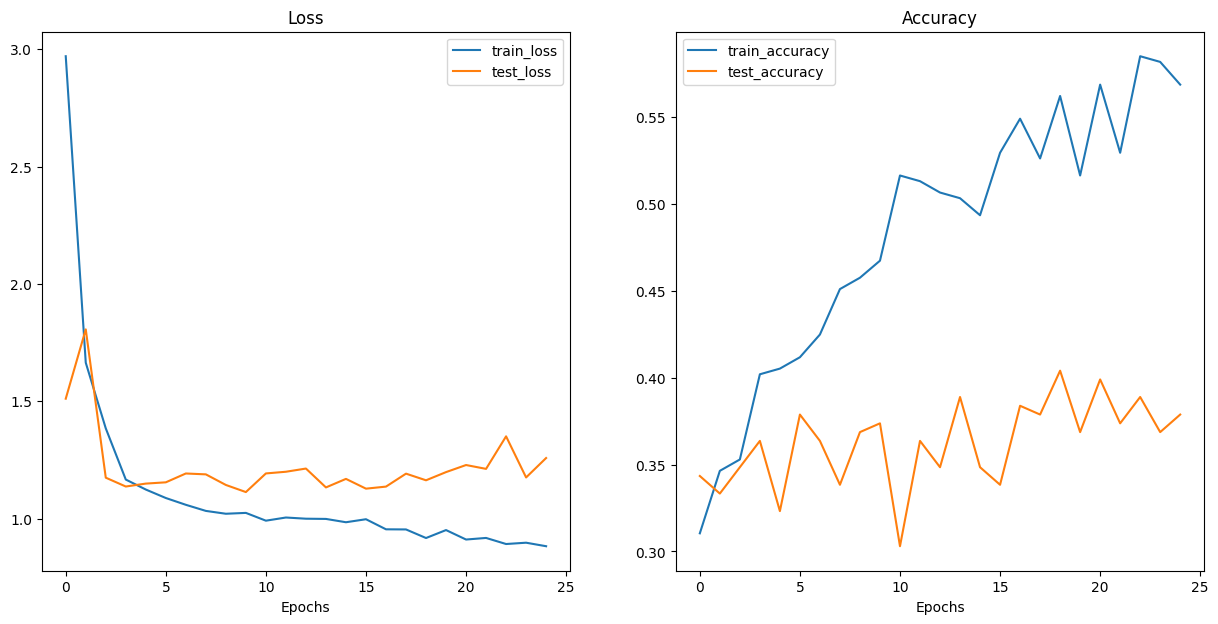

In [177]:
plot_loss_curves(model_0_results)